# Recommendation Systems

Recommender systems reduce information overload by estimating relevance: 
- Personalised recommendations
- Collaborative (tell me what's popular among my peers)
- Content-based (show me more of the same that I've liked)
- Knowledge-based (tell me what fits based on my needs)

Fully developed and deployed recommendation systems are extremely complex and resource intensive.

Have a look at the Advanced Recommender System once you are finished with this.

The two most common types of recommender systems are **Content-Based** and **Collaborative Filtering**.
- Content-Based: Focuses on the attributes of the items and give recommendations based on the similarity between them.

- Collaborative Filtering: Produces recommendations based on the knowledge of users' attitude to items - 'wisdom of the crowd'.
"People that bought this also bought..."

Collaborative Filtering can also be divided into **Memory-Based CF** and **Model-Based CF**. In the Advanced Recommender System we implemented Model-Based CF using Singular Value Decomposition (SVD) and Memory-Based CF using computing cosine similarity.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
columns_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=columns_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [4]:
movie_title = pd.read_csv('Movie_Id_Titles')


In [5]:
movie_title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
df = pd.merge(df, movie_title, on='item_id')

In [7]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [8]:
sns.set_style('white')

In [9]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [10]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [11]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

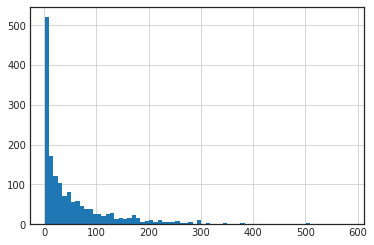

In [12]:
ratings['num of ratings'].hist(bins=70)

What you would expect: lots of movies with few number of ratings, very few and famous movies with lots of ratings

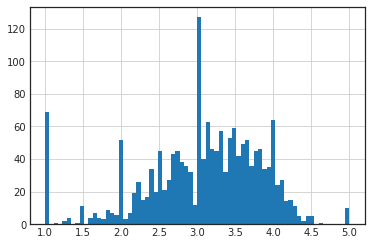

In [13]:
ratings['rating'].hist(bins=70)

Distributed normally, but interestingly enough, movies with low number of ratings will get average of whole integer numbers

/home/alvaro/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


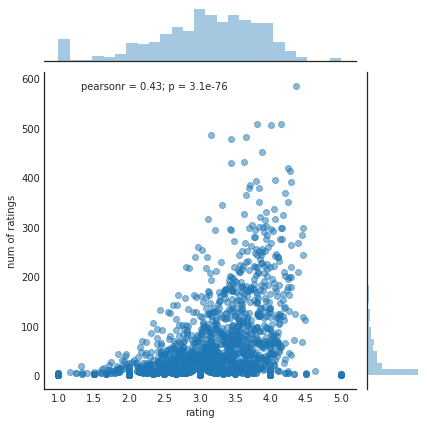

In [14]:
sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)

As you get more ratings, you tend to have better number of ratings: popular movies tend to be rated higher.

## Build the Recommendation System

In [15]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [16]:
moviemat = df.pivot_table(index='user_id', columns='title', values='rating')

In [17]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Logically, many users haven't seen ALL movies, thus the NaN

In [18]:
ratings.sort_values('num of ratings', ascending=False).head()

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


In [19]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [20]:
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [21]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings) #correlate with the column in starwars_user_ratings

/home/alvaro/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/alvaro/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [22]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/home/alvaro/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/alvaro/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [23]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [24]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


This shows how correlated the ratings for Star Wars are with the ratings for any other movie

In [25]:
corr_starwars.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0
"Outlaw, The (1943)",1.0
"Line King: Al Hirschfeld, The (1996)",1.0
Hurricane Streets (1998),1.0
"Good Man in Africa, A (1994)",1.0


This doesn't make much sense. In reality, this is because the only guy who rated those movies ALSO rated Star Wars with 5 stars.

We can filter that by removing movies with less than a certain number of ratings. Given the histogram above, we will use 150 ratings.

In [26]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])

In [27]:
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [29]:
threshold = 150
corr_starwars[corr_starwars['num of ratings'] > threshold].sort_values('Correlation', ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
"Sting, The (1973)",0.367538,241


The Sting? It might be that both SW and that are very popular.

In [30]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns=['Correlation'])

In [32]:
corr_liarliar.dropna(inplace=True)

In [33]:
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [34]:
corr_liarliar[corr_liarliar['num of ratings']> threshold].sort_values('Correlation', ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Pretty Woman (1990),0.469790,164
Indiana Jones and the Last Crusade (1989),0.414427,331
Top Gun (1986),0.405720,220
G.I. Jane (1997),0.397931,175
